In [14]:
from google.colab import drive; drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
dataset_path = '/content/drive/My Drive/mhealth_balanced_preprocessed.csv'
data = pd.read_csv(dataset_path)
data.head()

<ipython-input-22-4861e52ff204>:7: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path)


,chest_acc_x,chest_acc_y,chest_acc_z,ecg_1,ecg_2,ankle_acc_x,ankle_acc_y,ankle_acc_z,ankle_gyro_x,ankle_gyro_y,...,arm_acc_x,arm_acc_y,arm_acc_z,arm_gyro_x,arm_gyro_y,arm_gyro_z,arm_mag_x,arm_mag_y,arm_mag_z,label
0,-0.082298,0.100707,-0.109697,-0.040645,0.012529,-0.318837,0.209841,0.381243,-0.626800,-0.331064,...,0.308429,-0.396686,-0.247928,-1.055188,-0.385007,-0.283994,0.030973,-0.085350,-0.009639,standing_sitting
1,-0.145185,-0.058681,0.080943,0.029537,0.028832,-0.186470,0.240070,0.443979,0.477669,-0.021467,...,0.434662,-0.381911,0.396716,0.814344,-0.407283,1.095761,0.042972,-0.075806,0.002653,standing_sitting
2,-0.079641,-0.191486,0.010085,0.141002,0.138880,-0.160918,0.264784,0.482819,0.498755,0.066031,...,0.443040,-0.372538,0.383792,0.850914,-0.389458,1.118194,0.027122,-0.071250,-0.006657,standing_sitting
3,-0.131824,0.024539,0.401956,2.163932,0.974429,-0.423189,0.234660,0.427225,-1.208550,-0.021467,...,0.329354,-0.390973,0.021780,-1.009473,-0.402832,-0.340085,0.035511,-0.019771,0.005469,standing_sitting
4,-0.126107,0.260801,0.649338,-0.048902,0.053287,-0.267000,0.247715,0.370905,1.228038,-0.203171,...,0.247260,-0.317893,0.265003,1.093174,-0.656953,0.991055,0.022950,-0.094383,-0.003555,standing_sitting


In [24]:
from sklearn.preprocessing import LabelEncoder

data["label"] = data["label"].astype(str)

X = data.drop(columns=["label"]).values
y = data["label"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mappings:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Features shape:", X.shape)
print("Labels shape:", y_encoded.shape)


Label mappings: {'0': 0, 'jogging': 1, 'running': 2, 'standing_sitting': 3, 'walking': 4}
Features shape: (153600, 23)
Labels shape: (153600,)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (107520, 23) (107520,)
Validation set shape: (23040, 23) (23040,)
Test set shape: (23040, 23) (23040,)


In [26]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("LSTM input shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


LSTM input shapes:
X_train: (107520, 1, 23)
X_val: (23040, 1, 23)
X_test: (23040, 1, 23)


In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Attention
)

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Convolutional layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
conv1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1) 

conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
conv2 = MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)

# LSTM layers
lstm_out = LSTM(128, return_sequences=True)(conv2)
lstm_out = Dropout(0.3)(lstm_out)

# Self-attention layer
attention_output = Attention()([lstm_out, lstm_out])

# Additional LSTM layer
lstm_out_2 = LSTM(64, return_sequences=False)(attention_output)
lstm_out_2 = Dropout(0.3)(lstm_out_2)

# Fully connected layers
dense_1 = Dense(64, activation='relu')(lstm_out_2)
dense_1 = Dropout(0.3)(dense_1)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 1, 23)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 1, 64)          │          4,480 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 1, 64)          │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 1, 128)         │         24,704 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 1, 128)         │              0 │ conv1d_8[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ (None, 1, 128)         │        131,584 │ max_pooling1d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 1, 128)         │              0 │ lstm_16[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 1, 128)         │              0 │ dropout_19[0][0],      │
│                           │                        │                │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ (None, 64)             │         49,408 │ attention_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 64)             │              0 │ lstm_17[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          4,160 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 5)              │            325 │ dropout_21[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 214,661 (838.52 KB)

 Trainable params: 214,661 (838.52 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25, 
    batch_size=32,
    verbose=1
)


Epoch 1/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.8016 - loss: 0.4983 - val_accuracy: 0.9445 - val_loss: 0.1733
Epoch 2/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9487 - loss: 0.1703 - val_accuracy: 0.9520 - val_loss: 0.1487
Epoch 3/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9601 - loss: 0.1374 - val_accuracy: 0.9614 - val_loss: 0.1293
Epoch 4/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9642 - loss: 0.1244 - val_accuracy: 0.9664 - val_loss: 0.1134
Epoch 5/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9684 - loss: 0.1116 - val_accuracy: 0.9720 - val_loss: 0.0999
Epoch 6/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9720 - loss: 0.1047 - val_accuracy: 0.9697 - val_loss: 0.1063
Epoch 7/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9733 - loss: 0.0969 - val_accuracy: 0.9740 - val_loss: 0.0955
Epoch 8/25
3360/3360 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9743 - loss: 0

In [48]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Test Loss: 0.08047927916049957
Test Accuracy: 0.9801649451255798


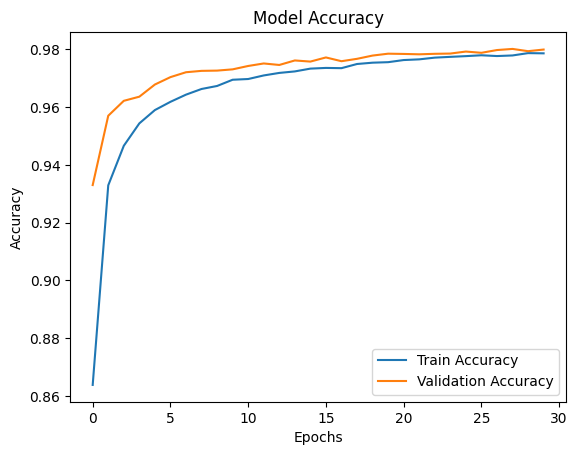

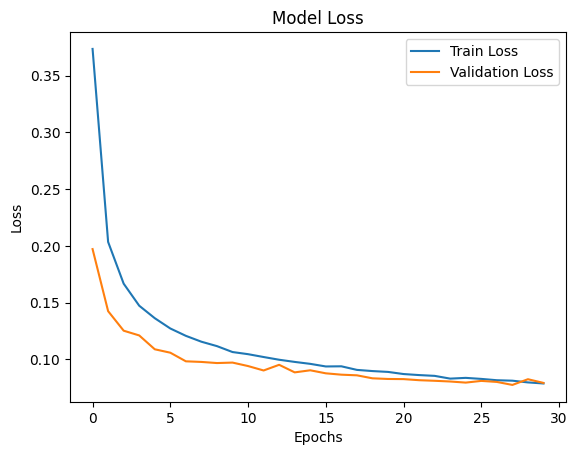

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
